# MIE 1624: Introduction to Data Science and Analytics
# Course Project: Fact or Fake News?
# Group 19
Prepared for the MIE 1624 Course Proect by:
- Syed Hamdan Mustafa
- Matthew Vassov
- Michael Attong
- Muhammad Farhan Riaz

Data source collected from the Leaders Price on DataCup: 
https://www.datacup.ca/main/competitions/leadersprize2019/about

#### Table of Contents:
- Reading Data
- Cleaning Data
- Data Exploration
- Model Preparation
- Model Implementation
- Model Results
- Neural Network implementation
- Submission code for the Datacup competition

#### Installing Libraries

In [147]:
!pip install numpy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install keras
!pip install tensorflow
!pip install sklearn
!pip install graphviz
!pip install seaborn==0.9.0

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import os
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')# Download resources

import graphviz
from IPython.display import display, Image

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) #setting constant figure size

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from keras import layers
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore') #ignore warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vassovma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


## Reading data

<b>Notice to reader:</b> Data used for the code is provided by Datacup. If you are running this code with a refreshed Kernel, please ensure that the right metadata and articles filepath are specified.

Link to Data Files (and all other files included in this submission):
https://drive.google.com/drive/folders/1MrkV6VWtQt3693axME4a-XCqq29Tvywe?usp=sharing
The data files are in a zip file labeled 'train.zip'. Note: these are the same as the ones on the datacup website. 


In [27]:
# These are the file paths to read the data from:
#Please download the data and unzip it from the link above (train.zip file). You will need to modify the path below to suit your needs
METADATA_FILEPATH = 'train/train.json'
ARTICLES_FILEPATH = 'train/train_articles/'

#'train/train.json'
#'train/train_articles/'

#'//SRVC/Homes$/vassovma/Desktop/train/train.json'
#'//SRVC/Homes$/vassovma/Desktop/train/train_articles/'

# Read in the metadata file
with open(METADATA_FILEPATH, 'r') as f:
    claims = json.load(f)

# Inspect the first claim
claim = claims[0]
print('Claim:', claim['claim'])
print('Label:', claim['label'])
print('Speaker:', claim['claimant'])
print('Date:', claim['date'])
print('Related Article Ids:', claim['related_articles'])

Claim: A line from George Orwell's novel 1984 predicts the power of smartphones.
Label: 0
Speaker: 
Date: 2017-07-17
Related Article Ids: [122094, 122580, 130685, 134765]


In [35]:
#Creating the claims dataframe
df_claims = pd.DataFrame(claims)
df_claims.columns = ['Claims', 'Claimant', 'Date', 'ID', 'Label', 'Related Articles']
df_claims.head()

,Claims,Claimant,Date,ID,Label,Related Articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


## 1- Data Cleaning

The claims and related articles will be cleaned in this section.

### 1.1- Cleaning claims data

In [36]:
def ClaimCleaning (df_preprocessing, col_name):
    """This function will be used to clean the text file"""
    
    #Step 1- Lower case all the tweets
    df_preprocessing.loc[:,'text_lower'] = df_preprocessing[col_name].apply(lambda x: x.lower()).copy()
    
    #Step 2- Remove hastags, urls, mentions
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls']=df_preprocessing["text_lower"].apply(lambda x:re.sub('(@[\w]+)|(^rt\s+)|(http[s]:\/\/[\w\.-\/]+[\s]*)|(http:\/\/[\w\.-\/]+[\s]*)|(#)|(â)',' ',x))
    
    #Step 3- Remove punctuations and special characters
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls_punct']=df_preprocessing["text_lower_without_hastags_mentions_urls"].apply(lambda x:re.sub('([^\w]+)',' ',x))
    
    #Step 4- Remove stopwords                                           
    stop_words=stopwords.words("english")
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords"]=df_preprocessing["text_lower_without_hastags_mentions_urls_punct"].apply(lambda x: str(" ".join(x for x in x.split() if x not in stop_words)))
    
    #Step 5- Remove emojis
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords_emojis"]= df_preprocessing["text_lower_without_hastags_mentions_urls_punct_stopwords"].apply(lambda x:re.sub('(\s)x\w+|xe2',' ',x))
    
                                                                                                                            
    return df_preprocessing                                                                                                                       

In [37]:
cleaned_text = ClaimCleaning(df_claims[["Claims"]], "Claims")

In [38]:
df_claims["Claims"] = cleaned_text.iloc[:,-1]
df_claims.head()

,Claims,Claimant,Date,ID,Label,Related Articles
0,line george orwell novel 1984 predicts power s...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,maine legislature candidate leslie gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,17 year old girl named alyssa carson trained n...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,1988 author roald dahl penned open letter urgi...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,comes fighting terrorism another thing know wo...,Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


### 1.2- Cleaning the related articles
##### Key assumption
In addition to cleaning the data, we have made the assumption that the label associated to the Claim is the label associated with the related articles. This assumption is made after learning from the competition organizers that it is not gaurenteed that the related articles are all factual (i.e. they could be inaccurate/fake). While there are several assumptions that can be made here, we have decided to assume that <b>Related Article Label = Claim Label</b>

In [39]:
#Seperating all the related articles into one dataframe
df2= df_claims.drop(["Claims", "Claimant","Date", "ID"], axis=1)
df2.head()

,Label,Related Articles
0,0,"[122094, 122580, 130685, 134765]"
1,2,"[106868, 127320, 128060]"
2,1,"[132130, 132132, 149722]"
3,2,"[123254, 123418, 127464]"
4,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [40]:
#breaking the articles down one by one. Assumption: Related articles in the same row share the same label
df_article= df2['Related Articles'].apply(pd.Series) \
    .merge(df2, right_index = True, left_index = True)\
    .drop(["Related Articles"], axis = 1) \
    .melt(id_vars = ['Label'], value_name = "Related Articles")\
    .drop("variable", axis = 1)\
    .dropna()

df_article['Related Articles'] = df_article[['Related Articles']].astype(int)
df_article.head()

,Label,Related Articles
0,0,122094
1,2,106868
2,1,132130
3,2,123254
4,2,41099


In [41]:
#Reading the articles
article=[]
idx_list = []
for i in df_article['Related Articles']:
    idx_list.append(i)
    with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % i), 'r', errors='ignore') as f:
        article.append(f.read())

In [42]:
df_article['article']= article #creating a dataframe for the articles
df_article.head()

,Label,Related Articles,article
0,0,122094,1984: George Orwell predicted 2017 almost 70 y...
1,2,106868,Republican who criticized Parkland students dr...
2,1,132130,FIRST PERSON TO COMPLETE NASAâ€™S PASSPORT PRO...
3,2,123254,How dangerous is measles? Tweet\n\n27 March 20...
4,2,41099,Remarks on counterterrorism at Stanford Univer...


In [43]:
cleaned_text= ClaimCleaning(df_article[["article"]], "article") #using the same cleaning function used for claims

In [44]:
df_article['article']= cleaned_text.iloc[:,-1]
df_article.head()

,Label,Related Articles,article
0,0,122094,1984 george orwell predicted 2017 almost 70 ye...
1,2,106868,republican criticized parkland students drops ...
2,1,132130,first person complete nasa passport program as...
3,2,123254,dangerous measles tweet 27 march 2013 many par...
4,2,41099,remarks counterterrorism stanford university œ...


## 2.0- Data Exploration

This section includes exploration of the claims data.

In [45]:
def convert_claims_to_words (claim): 
    """Custom function defined to parse out the words in each of the claims"""
    words=[]

    for sentence in claim:
        wordList = re.sub("[^\w]", " ",  sentence).split() #converts each claim into a list of words (creates a nested list)
        words.append(wordList)
    words= [item for sublist in words for item in sublist] #converts nested list into a 1D list to ease future implementation   
        
    return words

### 2.1- Exploring the different claims

#### 2.1.1- Word cloud for all claims (regardless of their truth rating)

In [46]:
WCstopwords=['say','one','says','see'] #ignore these words from the word cloud for this section

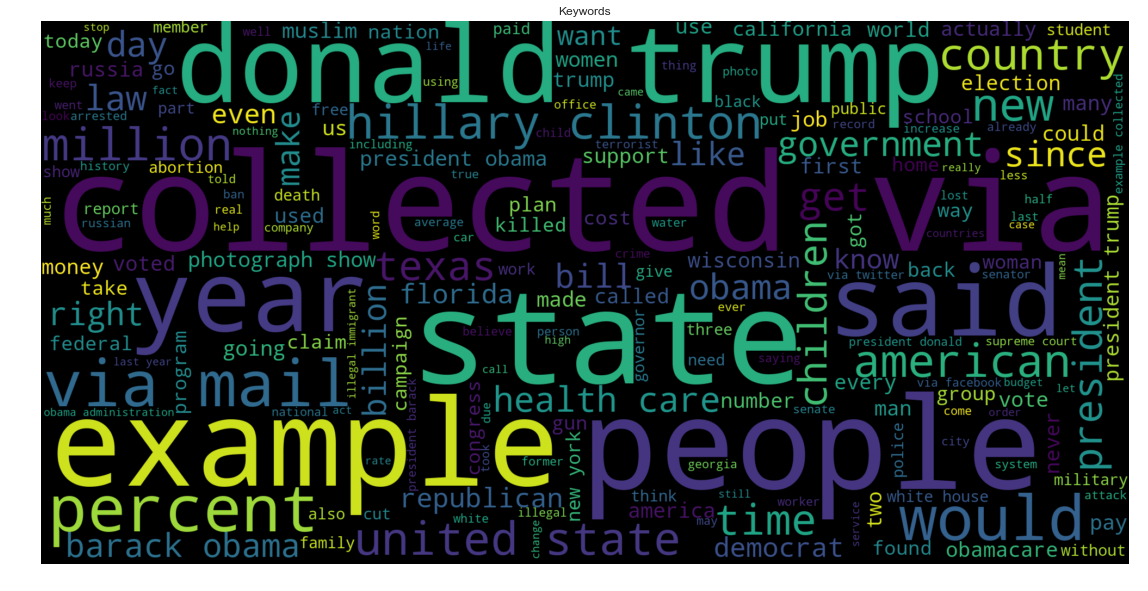

In [47]:
lib = convert_claims_to_words(df_claims["Claims"])
lib_str = ' '.join(lib)
wordcloud = WordCloud(width = 2000, height = 1000, stopwords = WCstopwords).generate(lib_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords')
plt.axis("off")
plt.show()

#### 2.1.2- Wordcloud of claims which have a rating label of 0

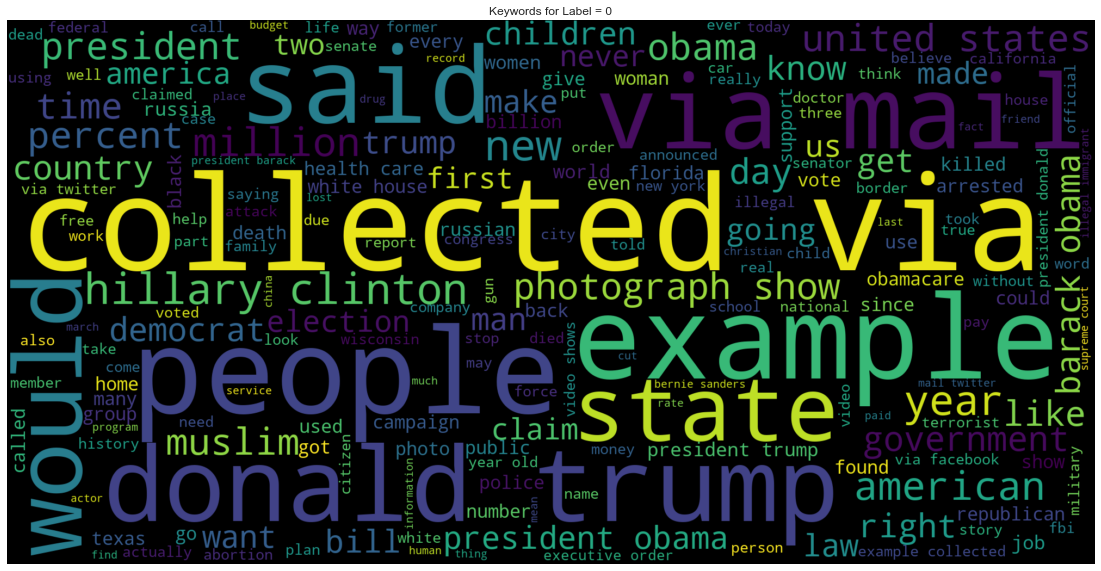

In [24]:
#Making a subset of df_claims where the label is 0
df_claims_0 = df_claims[df_claims['Label'] == 0]
lib_0 = convert_claims_to_words(df_claims_0["Claims"])
lib_str_0 = ' '.join(lib_0) 
wordcloud = WordCloud(width = 2000, height = 1000, stopwords = WCstopwords).generate(lib_str_0)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords for Label = 0')
plt.axis("off")
plt.show()

#### 2.1.2- Wordcloud claims which have a rating label of 1

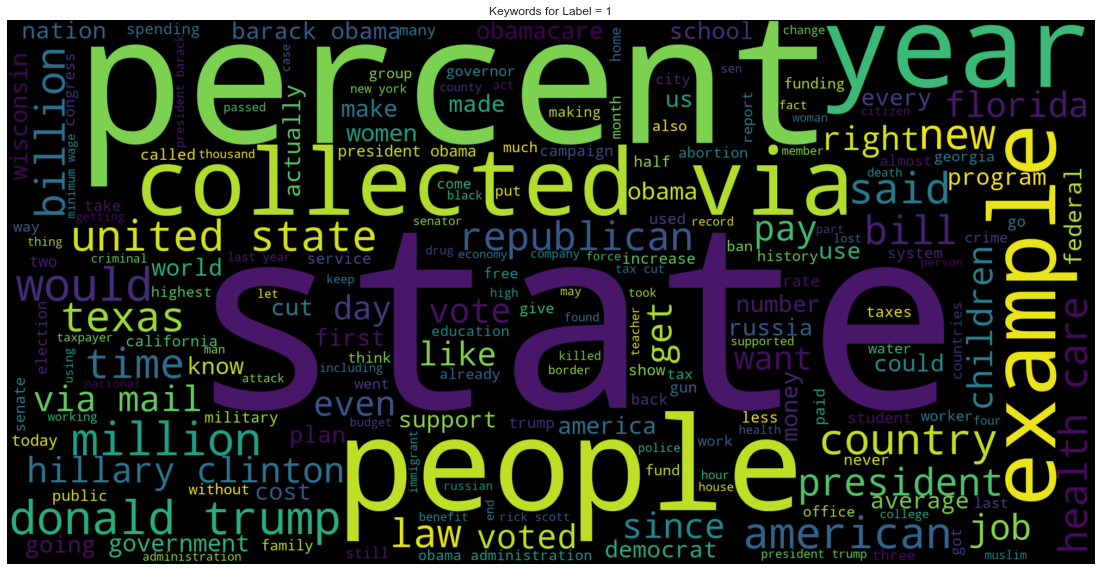

In [25]:
#Making a subset of df_claims where the label is 0
df_claims_1 = df_claims[df_claims['Label'] == 1]

lib_1 = convert_claims_to_words(df_claims_1["Claims"])
lib_str_1 = ' '.join(lib_1) 
wordcloud = WordCloud(width = 2000, height = 1000, stopwords = WCstopwords).generate(lib_str_1)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords for Label = 1')
plt.axis("off")
plt.show()

#### 2.1.3- Wordcloud claims which have a rating label of 2

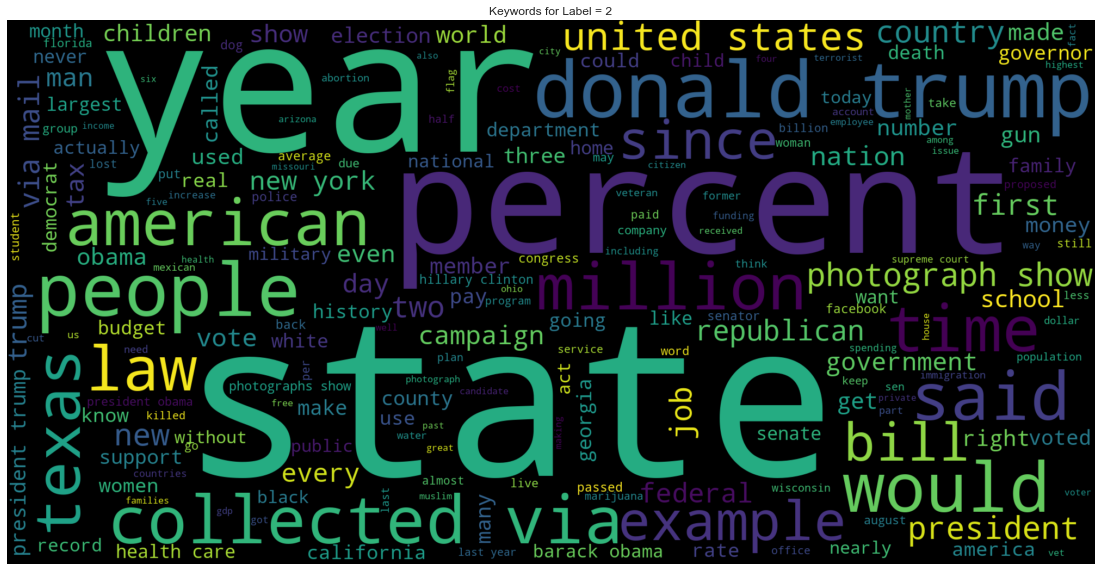

In [26]:
#Making a subset of df_claims where the label is 2
df_claims_2 = df_claims[df_claims['Label'] == 2]

lib_2 = convert_claims_to_words(df_claims_2["Claims"])
lib_str_2 = ' '.join(lib_2) 
wordcloud = WordCloud(width = 2000, height = 1000,  stopwords = WCstopwords).generate(lib_str_2)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords for Label = 2')
plt.axis("off")
plt.show()

#### 2.1.4- Count of the different labels

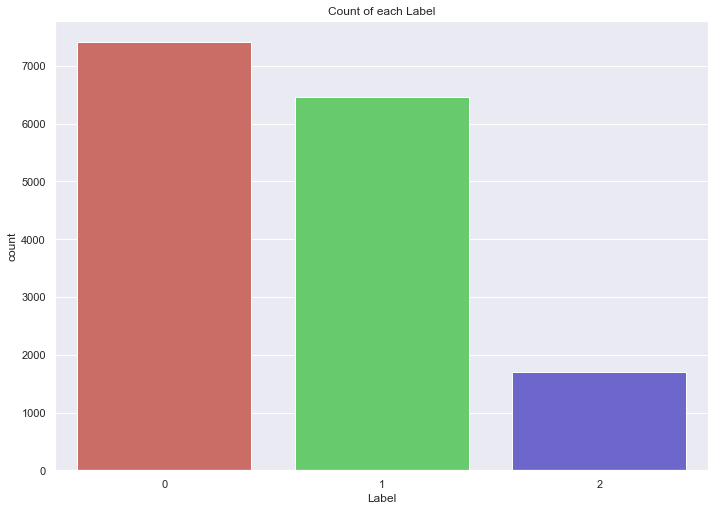

In [27]:
sns.set()

df_claims_subset = df_claims
df_claims_subset = df_claims_subset[df_claims_subset.Claimant != '']
sns.countplot(x='Label',palette="hls",data=df_claims)
plt.title("Count of each Label")
plt.show()

### 2.2- Exploring the different claimants

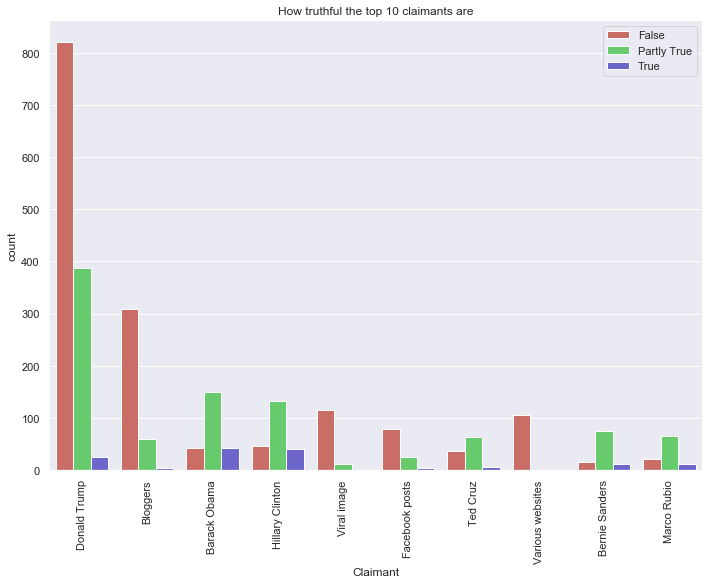

In [28]:
sns.countplot(x='Claimant', hue = 'Label',palette="hls",data=df_claims_subset, order=df_claims_subset.Claimant.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.legend(["False","Partly True","True"])
plt.title('How truthful the top 10 claimants are')
plt.show()

#### 2.3- Exploring the top claimant (Donald Trump)

In [29]:
WCstopwords=['say','one','says','see','said','year'] #ignore these words from the word cloud for this section

In [30]:
#Creating the dataframe for Trump claims
trump = df_claims_subset
trump = trump[trump.Claimant == 'Donald Trump']

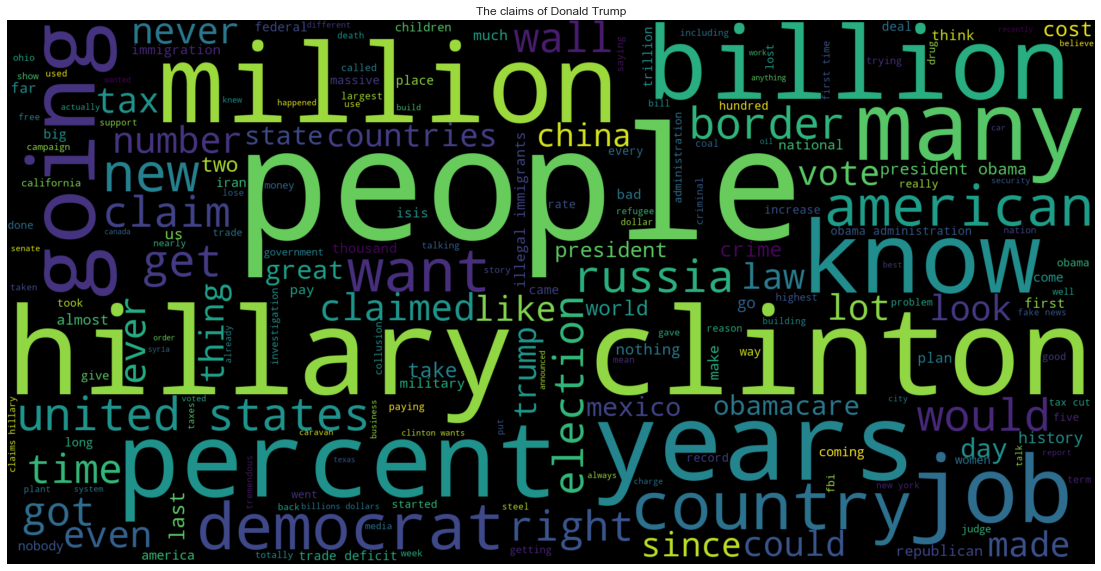

In [31]:
#Making a subset of df_claims where the label is 2
lib = convert_claims_to_words(trump['Claims'])
lib_str = ' '.join(lib) 
wordcloud = WordCloud(width = 2000, height = 1000, stopwords = WCstopwords).generate(lib_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('The claims of Donald Trump')
plt.axis("off")
plt.show()

Looking at the claims by the top claimant by year and month

In [32]:
trump['Date'] = pd.to_datetime(trump['Date'])
trump['Year'] = trump['Date'].map(lambda x: x.strftime('%Y'))
trump['Month'] = trump['Date'].map(lambda x: x.strftime('%m'))
trump['Day'] = trump['Date'].map(lambda x: x.strftime('%d'))

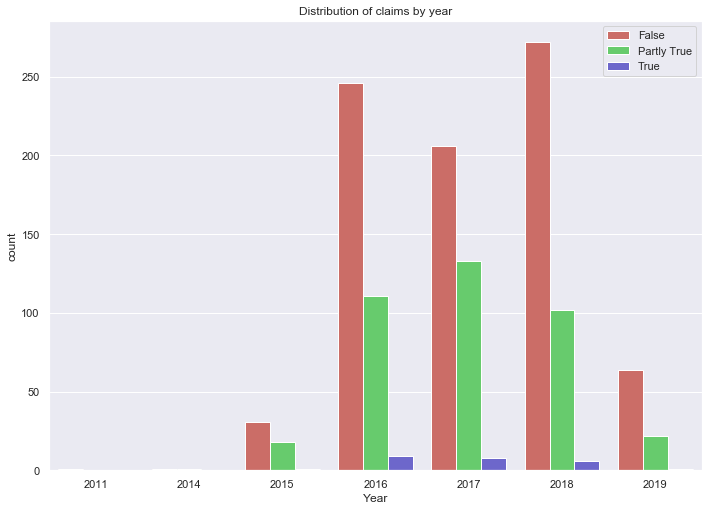

In [33]:
#Lets see how active Donald Trump is
sns.countplot(x='Year', hue = 'Label',palette="hls",data=trump)
plt.title("Distribution of claims by year")
plt.legend(["False","Partly True","True"])
plt.show()

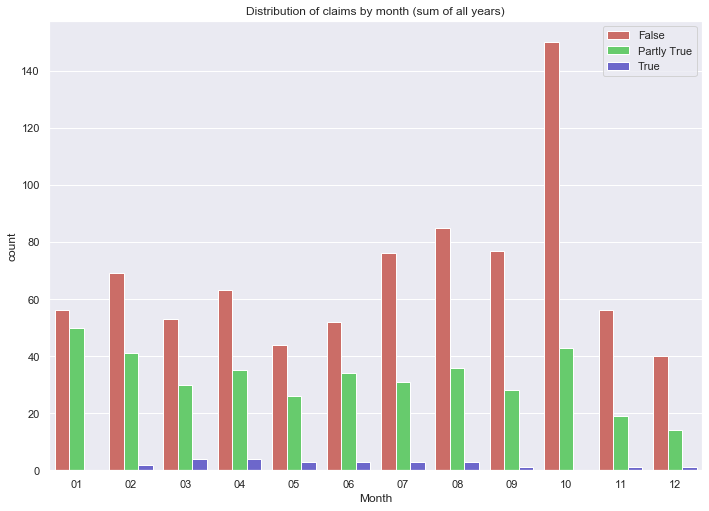

In [34]:
sns.countplot(x='Month', hue = 'Label',palette="hls",data=trump)
plt.title("Distribution of claims by month (sum of all years)")
plt.legend(["False","Partly True","True"])
plt.show()

The false claims are very high for the month of October. Lets dig further.

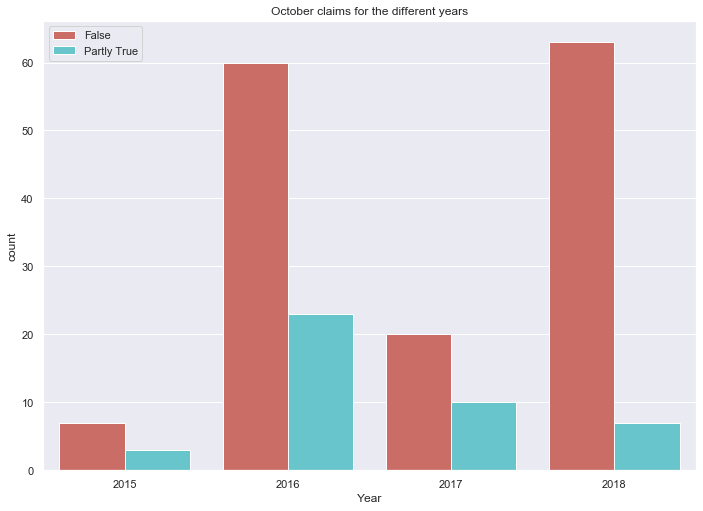

In [35]:
trump_month = trump
trump_month = trump_month[trump_month.Month == '10']
sns.countplot(x='Year', hue = 'Label',palette="hls",data=trump_month)
plt.legend(["False","Partly True","True"])
plt.title("October claims for the different years")
plt.show()

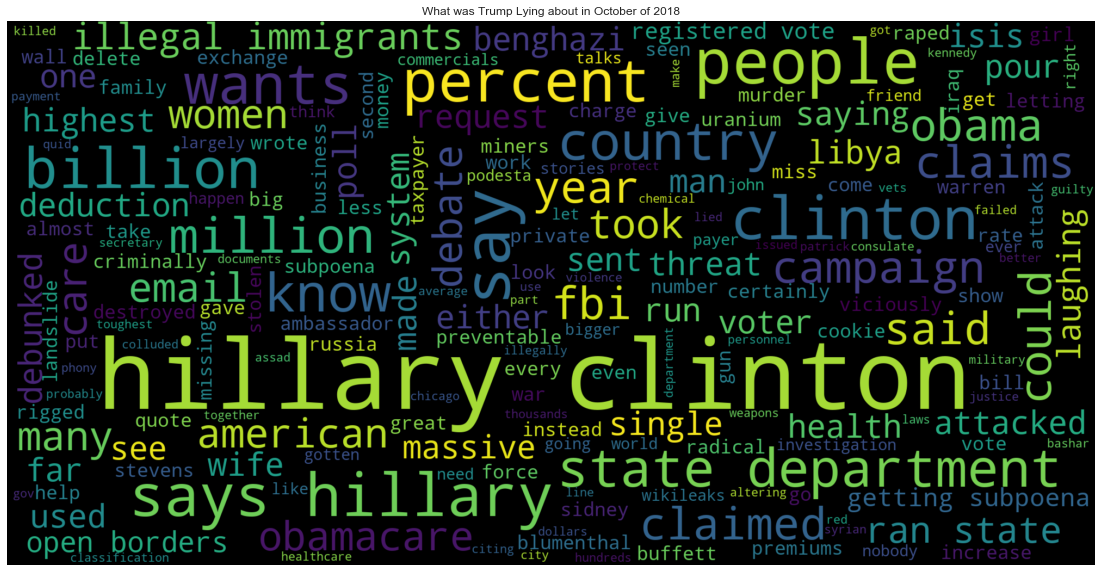

In [36]:
trump_month = trump_month[trump_month.Year == '2016']

#Making a subset of df_claims where the label is 0

WCstopwords=['donald trump', 'president donald','president', 'donald', 'trump', 'united','states']
lib = convert_claims_to_words(trump_month["Claims"])
lib_str = ' '.join(lib) 
wordcloud = WordCloud(width = 2000, height = 1000, stopwords = WCstopwords,).generate(lib_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('What was Trump Lying about in October of 2018')
plt.axis("off")
plt.show()

October 2016 was close to the US elections and that could be the major reason for the high volume of claims during the time period.

## 3.0- Model Preparation

The features could be selected as the claims or related articles or both. The targets would vary accordingly.

In [48]:
X_articles= df_article["article"]
X_claims= df_claims["Claims"]

In [49]:
y_articles= df_article["Label"]
y_claims= df_claims["Label"]

In [50]:
#Both claims and related articles?
X= pd.concat([X_articles, X_claims])
y= pd.concat([y_articles, y_claims])

#Only claims?
#X= X_claims
#y= y_claims

#Only articles?
#X= X_articles
#y= y_articles

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42) #70-30 split

#### TF-IDF Vectorizer

TF-IDF was used for this project. The number of features was varied extensively to get the best possible results.
ngram_range was also used in this case.

Note: The neural network section included its own embedding layer unrelated to this.

In [53]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 5000, ngram_range= (1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

#Convering the vectors into arrays to implement models
tfidf_train = tfidf_train.toarray() 
tfidf_test = tfidf_test.toarray()

## 4.0- Model Implementation

### 4.1- Decision Tree

Use graph viz!!

In [42]:
tree_cv = DecisionTreeClassifier()
tree_cv.fit(tfidf_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

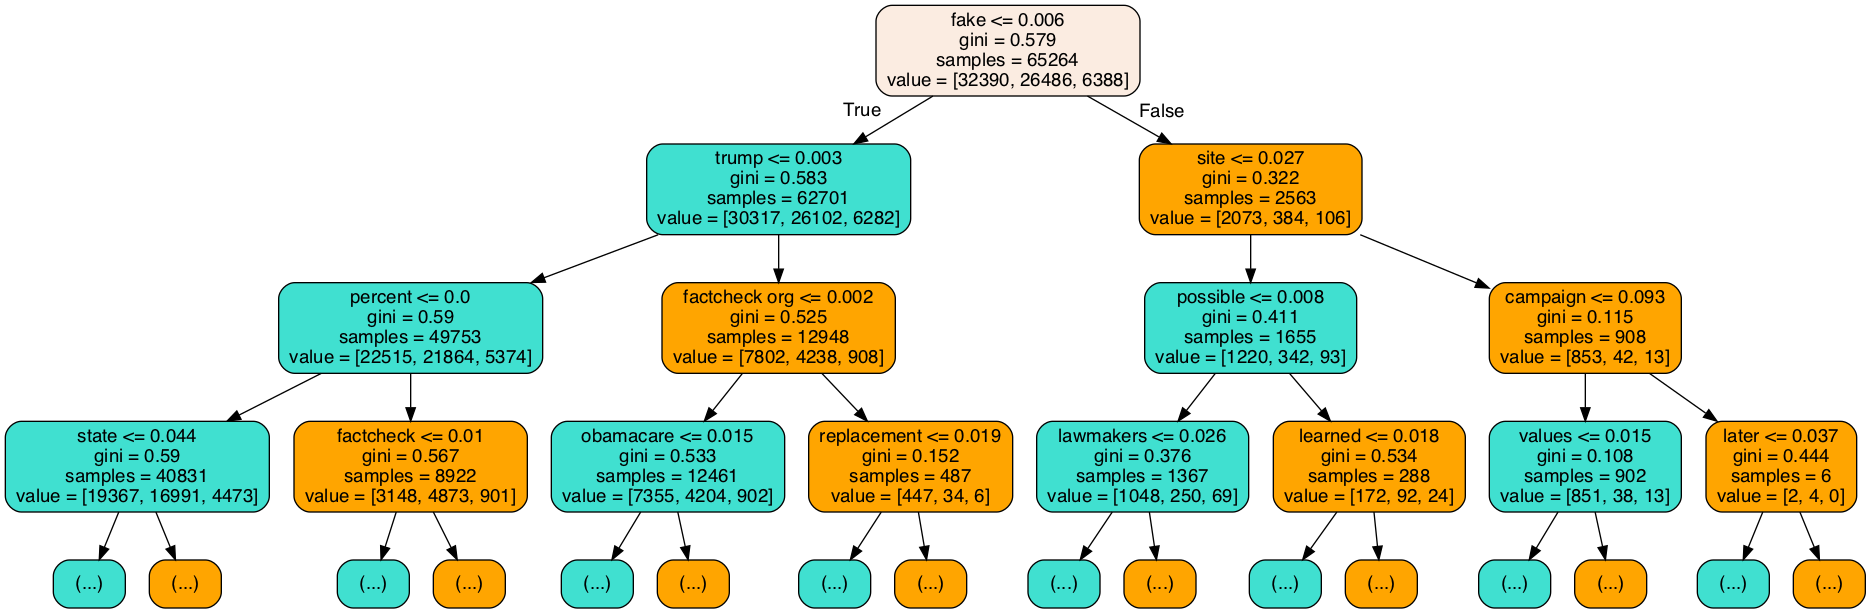

In [49]:
from sklearn import tree
import pydotplus
import collections
data_feature_names = tfidf_vectorizer.get_feature_names()
dot_data = tree.export_graphviz(tree_cv, out_file=None,filled=True,rounded=True,max_depth = 3,feature_names=data_feature_names)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')
Image("tree.png")

In [50]:
train_predictions= tree_cv.predict(tfidf_train)
test_predictions = tree_cv.predict(tfidf_test)

In [53]:
accuracy_train = accuracy_score(y_train, train_predictions)
accuracy_test= accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.9622456484432459
Test Set Accuracy: 0.5494261914125345


In [54]:
F1Score = f1_score(y_test, test_predictions, average = 'macro')
print('F1 Score: ',F1Score)

F1 Score:  0.43762479263229226


### 4.2- Random Forrest

In [141]:
forest_cv = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=5)

In [142]:
forest_cv.fit(tfidf_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [143]:
train_predictions= forest_cv.predict(tfidf_train)
test_predictions = forest_cv.predict(tfidf_test)

In [144]:
accuracy_train = accuracy_score(y_train, train_predictions)
accuracy_test= accuracy_score(y_test, test_predictions)

print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_))
print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Tuned Random Forest Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 6}
Train Set Accuracy: 0.7030215739151753
Test Set Accuracy: 0.589288906367309


In [145]:
F1Score = f1_score(y_test, test_predictions, average = 'macro')
print('F1 Score: ',F1Score)

F1 Score:  0.4080647911938155


### 4.3- Naive Bayes

In [132]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [133]:
train_predictions= nb_classifier.predict(tfidf_train)
test_predictions= nb_classifier.predict(tfidf_test)

In [134]:
accuracy_train = accuracy_score(y_train, train_predictions)
accuracy_test= accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.5917810737925963
Test Set Accuracy: 0.5912552286296522


In [135]:
F1Score = f1_score(y_test, test_predictions, average = 'macro')
print('F1 Score: ',F1Score)

F1 Score:  0.4218978966246973


### 4.4- Logistic Regression

In [128]:
#scaler= StandardScaler()
#tfidf_train= scaler.fit_transform(tfidf_train)
#tfidf_test= scaler.transform(tfidf_test)

model= LogisticRegression()
model.fit(tfidf_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

In [130]:
accuracy_train = accuracy_score(y_train, train_predictions)
accuracy_test= accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.6500980632507968
Test Set Accuracy: 0.6170676772371385


In [131]:
F1Score = f1_score(y_test, test_predictions, average = 'macro')
print('F1 Score: ',F1Score)

F1 Score:  0.4429132616205589


## 5.0- Results Discussion

First Try:

- 1000 features
- Combined claim and articles
- Best score with logistic regression- 59% and 0.412

Second Try: 

- 1500 features
- Combined claim and articles
- Best score with logistic regression- 59% and 0.4257

Third Try:

- 1800 features
- Combined claim and articles
- Best score with logistic regression- 59% and 0.4276

Fourth Try:

- 400 features
- Combined claim and articles
- Best score with random forest- 59% and 0.416

Fifth Try:

- 200 features
- Combined claim and articles
- Best score with random forest- 58% and 0.412

Sixth Try:

- 2500 features
- Combined claim and articles
- Best score with Logistic- 60% and 0.442

First Try:

- 1000 features
- Only claim
- Best score with logistic regression- 56% and 0.419 (NB came quite close)

Second Try: 

- 1500 features
- Only claim
- Best score with logistic regression- 54% and 0.415 (NB close)


Third Try:

- 400 features
- Only claim
- Best score with LR: 58% and 0.412


Fourth Try:

- 2500 features
- Only claim
- Best score with NB: 59% and 0.417

First Try:

- 1000 features
- Only articles
- Best score with RF: 59% and 0.419



Second Try:

- 400 features
- Only articles
- Best score with RF: 59% and 0.413


Fourth Try:

- 2500 features
- Only articles
- Best score with NB: 59% and 0.444

### 5.1- Logistic Regression Hyperparameter Tuning

In [54]:
C = [0.001,0.01,0.1,1,10]
multi_class = ['ovr', 'multinomial', 'auto']

for c in C: 
    for mc in multi_class:
        
        model= LogisticRegression(C=c, multi_class = mc,solver='lbfgs')
        model.fit(tfidf_train,y_train)

        test_predictions= model.predict(tfidf_test)

        accuracy_test= accuracy_score(y_test, test_predictions)
        F1Score = f1_score(y_test, test_predictions, average = 'macro')
        
        print(f"Test Set Accuracy: {accuracy_test} at C = {c} and multi_class = {mc}")
        print(f"F1 Score: {F1Score} at C = {c} and multi_class = {mc}\n\n")

Test Set Accuracy: 0.5010546637588932 at C = 0.001 and multi_class = ovr
F1 Score: 0.22318994775029774 at C = 0.001 and multi_class = ovr


Test Set Accuracy: 0.5131028565299774 at C = 0.001 and multi_class = multinomial
F1 Score: 0.2530561307575175 at C = 0.001 and multi_class = multinomial


Test Set Accuracy: 0.5131028565299774 at C = 0.001 and multi_class = auto
F1 Score: 0.2530561307575175 at C = 0.001 and multi_class = auto


Test Set Accuracy: 0.5779557398734404 at C = 0.01 and multi_class = ovr
F1 Score: 0.38156861646594153 at C = 0.01 and multi_class = ovr


Test Set Accuracy: 0.5911479746880698 at C = 0.01 and multi_class = multinomial
F1 Score: 0.39929510078733027 at C = 0.01 and multi_class = multinomial


Test Set Accuracy: 0.5911479746880698 at C = 0.01 and multi_class = auto
F1 Score: 0.39929510078733027 at C = 0.01 and multi_class = auto


Test Set Accuracy: 0.6107754459976404 at C = 0.1 and multi_class = ovr
F1 Score: 0.42338628805508044 at C = 0.1 and multi_class = ov

### 5.2- Plotting the Confusion Matrix

In [55]:
model= LogisticRegression(C = 10, multi_class = 'multinomial',solver='lbfgs')
model.fit(tfidf_train,y_train)

test_predictions= model.predict(tfidf_test)

accuracy_test= accuracy_score(y_test, test_predictions)
F1Score = f1_score(y_test, test_predictions, average = 'macro')

Text(0.5, 12.5, 'Predicted')

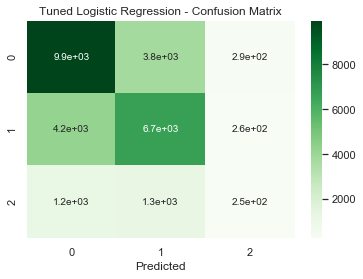

In [56]:
cm=confusion_matrix(y_test, test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Greens',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('Tuned Logistic Regression - Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

## 6.0- Neural Network Implementation

Keras is a deep learning and neural networks API by François Chollet which is capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft).

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases. Link: https://realpython.com/python-keras-text-classification/

This little helper function to visualize the loss and accuracy for the training and testing data based on the History callback. This callback, which is automatically applied to each Keras model, records the loss and additional metrics that can be added in the .fit() method. In this case, we are only interested in the accuracy. This helper function employs the matplotlib plotting library:

In [45]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

This would map semantically similar words close on the embedding space like numbers or colors. If the embedding captures the relationship between words well, things like vector arithmetic should become possible. A famous example in this field of study is the ability to map King - Man + Woman = Queen.

Using the word embedding from Keras.

In [46]:
X_articles= df_article["article"]
X_claims= df_claims["Claims"]

y_articles= df_article["Label"]
y_claims= df_claims["Label"]

The dense neural network and convulational neural network were trained on both the articles and claims dataset.

In [93]:
#Both claims and related articles
X= pd.concat([X_articles, X_claims])
y= pd.concat([y_articles, y_claims])

In [94]:
y_onehot= pd.get_dummies(y) #We need to one hot encode the targets to use softmax

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state = 42)

In [96]:
#Keras embedding.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### 6.1- Dense Neural Network

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:m

In [115]:
embedding_dim = 50
regularizers.l1_l2(l1=0.01, l2=0.01) #to deal with overfitting

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen)) #Embedding layer
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.1))) #3 outputs since there are three targets
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 100, 50)           14872250  
_________________________________________________________________
global_max_pooling1d_32 (Glo (None, 50)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_66 (Dense)             (None, 3)                 93        
Total params: 14,873,873
Trainable params: 14,873,873
Non-trainable params: 0
_________________________________________________________________


Train on 10888 samples, validate on 4667 samples
Epoch 1/20
10888/10888 [==============================] - 4s 326us/step - loss: 0.9809 - accuracy: 0.4851 - val_loss: 0.9401 - val_accuracy: 0.5217
Epoch 2/20
10888/10888 [==============================] - 3s 316us/step - loss: 0.8960 - accuracy: 0.6003 - val_loss: 0.8944 - val_accuracy: 0.5871
Epoch 3/20
10888/10888 [==============================] - 3s 317us/step - loss: 0.7969 - accuracy: 0.6672 - val_loss: 0.8840 - val_accuracy: 0.5935
Epoch 4/20
10888/10888 [==============================] - 3s 313us/step - loss: 0.6807 - accuracy: 0.7277 - val_loss: 0.9135 - val_accuracy: 0.5867
Epoch 5/20
10888/10888 [==============================] - 3s 304us/step - loss: 0.5487 - accuracy: 0.7895 - val_loss: 0.9853 - val_accuracy: 0.5809
Epoch 6/20
10888/10888 [==============================] - 3s 303us/step - loss: 0.4196 - accuracy: 0.8520 - val_loss: 1.0826 - val_accuracy: 0.5614
Epoch 7/20
10888/10888 [==============================] - 3s 31

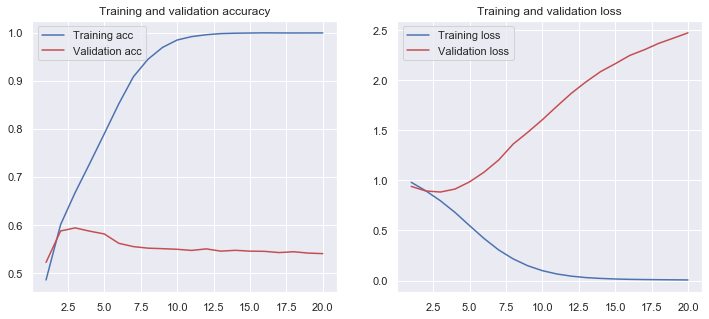

In [52]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 100)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [53]:
train_predictions= model.predict_classes(X_train)
test_predictions= model.predict_classes(X_test)

In [54]:
class_labels = np.argmax(np.array(y_test), axis=1) #to convert the labels from one hot encoding to measure f1 score
F1Score = f1_score(class_labels, test_predictions, average = 'macro')
print('F1 Score: ',F1Score)

F1 Score:  0.44123175026208855


The model takes a long time to run since there are around 15 million parameters. The model was also run for just the claims with the results being compareable to this.

The neural network model starts overfitting after a few epochs, this can be clearly seen from the graph.

The F1 score is similar to the one obtained from Logistic Regression.

### 6.2- Convulational Neural Network

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

In [97]:
embedding_dim = 50

regularizers.l1_l2(l1=0.01, l2=0.01)

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(30, activation='relu',kernel_regularizer=regularizers.l2(0)))
model.add(layers.Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(0)))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 100, 50)           14872250  
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 94, 32)            11232     
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 30)                990       
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 93        
Total params: 14,884,565
Trainable params: 14,884,565
Non-trainable params: 0
_________________________________________________________________


Train on 65264 samples, validate on 27971 samples
Epoch 1/30
65264/65264 [==============================] - 151s 2ms/step - loss: 0.9001 - accuracy: 0.5581 - val_loss: 0.8630 - val_accuracy: 0.5967
Epoch 2/30
65264/65264 [==============================] - 150s 2ms/step - loss: 0.7985 - accuracy: 0.6471 - val_loss: 0.8590 - val_accuracy: 0.5981
Epoch 3/30
65264/65264 [==============================] - 150s 2ms/step - loss: 0.6572 - accuracy: 0.7361 - val_loss: 0.9232 - val_accuracy: 0.5919
Epoch 4/30
65264/65264 [==============================] - 150s 2ms/step - loss: 0.4962 - accuracy: 0.8196 - val_loss: 1.0582 - val_accuracy: 0.5812
Epoch 5/30
65264/65264 [==============================] - 150s 2ms/step - loss: 0.3848 - accuracy: 0.8763 - val_loss: 1.1545 - val_accuracy: 0.5736
Epoch 6/30
65264/65264 [==============================] - 150s 2ms/step - loss: 0.3154 - accuracy: 0.9081 - val_loss: 1.2578 - val_accuracy: 0.5728
Epoch 7/30
65264/65264 [==============================] - 150s

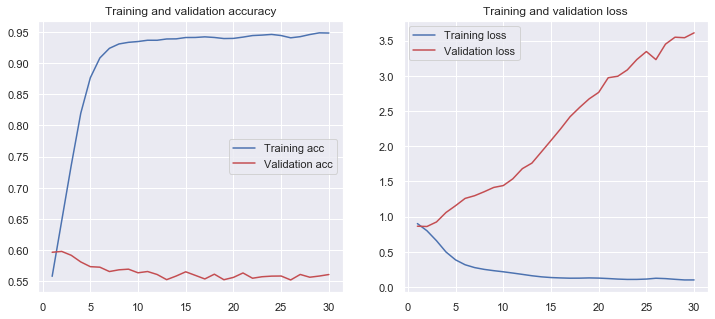

In [98]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=100)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [99]:
train_predictions= model.predict_classes(X_train)
test_predictions= model.predict_classes(X_test)

In [100]:
class_labels = np.argmax(np.array(y_test), axis=1) #to convert the labels from one hot encoding to measure f1 score
F1Score = f1_score(class_labels, test_predictions, average = 'macro')
print('F1 Score: ',F1Score)

F1 Score:  0.45040857238556065


In [104]:
model_json = model.to_json()
with open("neural_model.json", "w") as json_file:
    json_file.write(model_json)

In [105]:
model.save_weights("neural_model.h5")
print("Saved model to disk")

Saved model to disk


### 6.2.1- Hyperparameter optimization

Hyperparameter optimization is a classical feature that is used often in machine learning to improve the model.

One popular method for hyperparameter optimization for neural network is grid search. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, random search, which you’ll see in action here, simply takes random combinations of parameters. This is done mainly because the grid search would take a massive amount of computational time and we do not have systems suited for that kind of operations.

In [59]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [60]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[3000, 4000, 5000], 
                  embedding_dim=[50,100],
                  maxlen=[100])

In [79]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

    
X= df_claims["Claims"].values
y= df_claims["Label"].values
    

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 105.2min finished


In [117]:
grid_result.best_score_
grid_result.best_params_

{'vocab_size': 17751,
 'num_filters': 32,
 'maxlen': 100,
 'kernel_size': 7,
 'embedding_dim': 50}

These numbers were taken and adjusted in the earlier CNN model and the model was retrained.

### 6.3- Discussion of results

In summary, the neural network models was trained for various cases and the results were noted. The best score obtained from the neural network models is through the convulational neural network which produced a F1 score of 0.45. It should be noted that Logistic Regression gave a F1 score of 0.44 which competes reasonably well.

It goes to show that sometimes the simpler models could perform just as well as the complex ones. The neural network took a long time to train specially when the related articles were included (the number of parameters exceeded 14 million). 

There could be more versions of neural network that could be used for better results.

## 7- Submission code to Datacup competition

Below is the code used for building the Docker image. 
The following files were copied into the image
- <b>requirements.txt</b> which contained all the necessary modules which require to be installed
- <b>finalized_model.sav</b> which contains our trained Naive Bayes model 
- <b>stopwords.txt</b> which contains all the stopwords we need the model to use
- <b>submission.py</b> which contains our code which loads the finalized model, inputs the test data and produces predictions.

As a result of this submission, <b>we achieved a score of 0.312152</b> on the DataCup challenge (see team name: Kernel Sanders on the leaderboard)

In [ ]:
'''
FROM python:3
COPY requirements.txt /usr/local/
COPY finalized_model.sav /usr/local/
COPY stopwords.txt /usr/local/
WORKDIR /usr/local/
RUN pip install -r requirements.txt
COPY submission.py /usr/local/
CMD [ "python3", "/usr/local/submission.py" ]

'''

Included below is the code from our <b>submission.py</b> file

In [ ]:
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, KFold
import re
import nltk
from nltk.corpus import stopwords

import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore') #ignore warnings


# #### Reading data
import json
import os
import pandas as pd
from random import randint


METADATA_FILEPATH = '/usr/local/dataset/metadata.json'
ARTICLES_FILEPATH = '/usr/local/dataset/articles'

# This is the filepath where the predictions should be written to.
PREDICTIONS_FILEPATH = '/usr/local/predictions.txt'
STOPWORDS = '/usr/local/stopwords.txt'

# Read in the metadata file.
with open(METADATA_FILEPATH, 'r') as f:
    claims = json.load(f)
    
stop_words = pd.read_csv(STOPWORDS, header = None)

df_claims = pd.DataFrame(claims)
#df_claims = df_claims.drop(['label','claimant','date'], axis =1)

def TweetsCleaning (df_preprocessing, col_name):
    """This function will be used to clean the tweets file"""
    
    #Step 1- Lower case all the tweets
    df_preprocessing.loc[:,'text_lower'] = df_preprocessing[col_name].apply(lambda x: x.lower()).copy()
    
    #Step 2- Remove hastags, urls, mentions
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls']=df_preprocessing["text_lower"].apply(lambda x:re.sub('(@[\w]+)|(^rt\s+)|(http[s]:\/\/[\w\.-\/]+[\s]*)|(http:\/\/[\w\.-\/]+[\s]*)|(#)|(â)',' ',x))
    
    #Step 3- Remove punctuations and special characters
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls_punct']=df_preprocessing["text_lower_without_hastags_mentions_urls"].apply(lambda x:re.sub('([^\w]+)',' ',x))
    
    #Step 4- Remove stopwords                                           
    #stop_words=stopwords.words("english")
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords"]=df_preprocessing["text_lower_without_hastags_mentions_urls_punct"].apply(lambda x: str(" ".join(x for x in x.split() if x not in stop_words)))
    
    #Step 5- Remove emojis
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords_emojis"]= df_preprocessing["text_lower_without_hastags_mentions_urls_punct_stopwords"].apply(lambda x:re.sub('(\s)x\w+|xe2',' ',x))
    
                                                                                                                            
    return df_preprocessing    

#Data Cleaning step
cleaned_text= TweetsCleaning(df_claims[["claim"]], "claim")
df_claims["claim"] = cleaned_text.iloc[:,-1]

X_claims= df_claims["claim"]

X = X_claims
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 200, ngram_range= (1,2))
tfidf_test = tfidf_vectorizer.fit_transform(X)
tfidf_test = tfidf_test.toarray()


# load the model from disk
import pickle
filename = '/usr/local/finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(tfidf_test)
y_pred_df = pd.DataFrame(y_pred, columns = ['label']).astype(int)

claim_id_df = df_claims['id']

pred_df = pd.merge(claim_id_df,y_pred_df, left_index=True, right_index=True)
# Create a predictions file.
print('\nWriting predictions to:', PREDICTIONS_FILEPATH)

pred_df.to_csv(r'/usr/local/predictions.txt', header=None, index=None, sep=',', mode='a')

print('done')
'''
